***
# Lab 3 ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***
 

# Business Understanding 1

>For this lab, the team used a data set from Kaggle named: “2015 Flight Delays and Cancellations.” The data set contains 3 spreadsheets containing airport, airline, and flight information. The purpose of the data set is to provide consumers with information about the quality of services provided to them by airlines. Several attributes contained in the data set include: flight numbers, scheduled departure, departure delay, flight cancellations, and time spent in the air. For a full list of attributes in the data set, as well as their data types, please visit this site. 

>This data set is meaningful as it contains decision criteria that customers evaluate when determining which airline to fly with. For example, if a customer knows that a specific airline has the most cancellations, they are likely to not fly with that airline. Similarly, if a customer knows that the overall experience provided by a specific airline is poor, they will not fly with them. Additionally, this data set is meaningful to airlines because they can use the data to identify factors that are contributing to flight delays. After identifying the factors that are influencing delays, airlines can make modifications to their operations to minimize future delays.  

>For this lab, the team chose to predict flight delays and flight departure delays. To predict delays, the team created a binary attribute named `is_delay`. Seeing that the departure delay attribute is continuous, the team will predict this outcome as a regression problem. The team will evaluate the effectiveness of the regression algorithm with tenfold cross validation and by the model’s, R^2, MSE. Conversely the `is_delay` attribute is categorical and will be evaluated as classification problem. The team will evaluate the effectiveness of the classification algorithm using tenfold cross validation, model accuracy and AUC. 

### The team will know that they have mined useful knowledge from the data set if they are able to: 
 1. Identify related attributes and trends that exist in the data set.  
 2. Determine which variables are correlated with one another.   
 3. Create a prediction algorithm for the attributes: `departure_delay` and `is_delay`, using the effectiveness metrics of R^2 and MSE for `departure_delay` and model accuracy and AUC for `is_delay` to evaluate model performance. 
***

## Data Understanding 1:

> The team used a data set from Kaggle containing attributes about 2015 airline delays. The meaningfulness of the data is to provide both airlines and customers with information relevant to flight delays. This data is useful as it helps customers make decisions about which airline they fly with, and it helps airlines determine what the cause(s) of flight delays are. From a business perspective, knowing this information is critical as it drives an organization’s bottom line.  

> To get better insight into the attributes contained in the data set and their data types, the team ran `df.info(verbose=True,show_counts=True)` in Python. The full output from the command is found in the team’s code, however, 5 takeaways from the output are:  

> **1. The data set contains 5,819,079 entries.**<br> 
> **2. The data set contains 45 columns.**  <br>
> **3. There are 20 columns classified with the data type, float.**<br>
> **4. There are 11 columns classified with the data type, int.** <br>
> **5. There are 14 columns classified with the data type, object.**

> For additional context around attributes in the data set, the team created a data dictionary. The data dictionary contains attribute names, attribute descriptions, and attribute data types and is useful for business understanding. The data dictionary is found below: 

## Curating Data Sets

> In this section, the team merged the three files from Kaggle to create a curated data set that was used during this lab. The three files included flight information, airport information and airline information.

In [1]:
#import packages
import pandas as pd
import numpy as np
from numpy import mean, std
import seaborn as sns
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import time
import warnings

In [2]:
#remove warnings after verifying code
warnings.filterwarnings("ignore")

In [3]:
df_flights = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/flights.csv',low_memory = False)

In [4]:
df_airports = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airports.csv',low_memory = False)

In [5]:
df_airlines = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airlines.csv',low_memory = False)

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [8]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [10]:
#merge flight and airline information
df_merge_airline = df_flights.merge(df_airlines, left_on = 'AIRLINE', right_on = 'IATA_CODE',how='left')
df_merge_airline.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_y
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.


In [11]:
#find airports with missing LATITUDE
df_airports[df_airports['LATITUDE'].isna() == True]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [12]:
#impute missing lat/long values from:https://www.airnav.com/airport/
#ECP:
#    lat:30.3582408
#    long:-85.7956022
#PGB
#    lat:44.6509444
#    long:-73.4681389
#UST:
#    lat:29.9592503
#    long:-81.3397292

lat_inpute = {
    'ECP': 30.3582408,
    'PBG': 44.6509444,
    'UST': 29.9592503
}
long_inpute = {
    'ECP': -85.7956022,
    'PBG': -73.4681389,
    'UST': -81.3397292
}
#missing airport lat/long IATA CODE

missing_lat_long = ['ECP','PBG','UST']

df_airports['LATITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(lat_inpute)
df_airports['LONGITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(long_inpute)

In [13]:
#merge origin airport information to merged data 
df_merge_origin = df_merge_airline.merge(df_airports, left_on = 'ORIGIN_AIRPORT',right_on = 'IATA_CODE', how='left')

In [14]:
rename_dict_origin =  {'CITY':'CITY_ORIGIN',
                'STATE':'STATE_ORIGIN',
                'COUNTRY':'COUNTRY_ORIGIN',
                'LATITUDE':'LATITUDE_ORIGIN',
                'LONGITUDE':'LONGITUDE_ORIGIN'}
df_merge_origin.rename(columns=rename_dict_origin,inplace = True)

In [15]:
#merge destination airport information to dataset
df_merge_final = df_merge_origin.merge(df_airports,left_on = 'DESTINATION_AIRPORT',right_on = 'IATA_CODE',how='left')

In [16]:
rename_dict_dest =  {'CITY':'CITY_DESTINATION',
                'STATE':'STATE_DESTINATION',
                'COUNTRY':'COUNTRY_DESTINATION',
                'LATITUDE':'LATITUDE_DESTINATION',
                'LONGITUDE':'LONGITUDE_DESTINATION'}
df_merge_final.rename(columns=rename_dict_dest,inplace = True)

In [17]:
df_merge_final.columns= df_merge_final.columns.str.strip().str.lower()

In [18]:
df_ordered = df_merge_final.copy(deep=True)

In [19]:
col_order = ['year','month','day','day_of_week','airline_x','airline_y','flight_number','tail_number',
             'origin_airport','airport_x','city_origin','state_origin','country_origin','latitude_origin','longitude_origin',
             'destination_airport','airport_y','city_destination','state_destination','country_destination','latitude_destination','longitude_destination',
             'scheduled_departure','departure_time','departure_delay','taxi_out','wheels_off','scheduled_time','elapsed_time','air_time','distance',
             'wheels_on','taxi_in','scheduled_arrival','arrival_time','arrival_delay','diverted','cancelled','cancellation_reason','air_system_delay',
             'security_delay','airline_delay','late_aircraft_delay','weather_delay']

In [20]:
df_ordered = df_ordered[col_order]

In [21]:
rename_dict_merged =  {'airline_x':'airline_cd',
                       'airline_y':'airline_name',
                       'airport_x': 'airport_origin',
                       'airport_y':'airport_destination'}
df_ordered.rename(columns=rename_dict_merged,inplace = True)

In [22]:
df_ordered.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,American Airlines Inc.,2336,N3KUAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,US Airways Inc.,840,N171US,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,American Airlines Inc.,258,N3HYAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,Alaska Airlines Inc.,135,N527AS,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_ordered.to_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv')

In [24]:
#reading in data set from merged files
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [25]:
#removing unwanted column from previous export
df = df.drop(columns = ['Unnamed: 0'])

In [26]:
df.info(show_counts = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 44 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   year                   5819079 non-null  int64  
 1   month                  5819079 non-null  int64  
 2   day                    5819079 non-null  int64  
 3   day_of_week            5819079 non-null  int64  
 4   airline_cd             5819079 non-null  object 
 5   airline_name           5819079 non-null  object 
 6   flight_number          5819079 non-null  int64  
 7   tail_number            5804358 non-null  object 
 8   origin_airport         5819079 non-null  object 
 9   airport_origin         5332914 non-null  object 
 10  city_origin            5332914 non-null  object 
 11  state_origin           5332914 non-null  object 
 12  country_origin         5332914 non-null  object 
 13  latitude_origin        5332914 non-null  float64
 14  longitude_origin  

> The team ran df.info() to create the data dictionary shown above. df.info() provided the team with column indeces, with column names, and with the data types of each column. This information was useful as it helped the team understand how the computer was reading the variables and it helped the team identify variables whose data types may need to be modified. An example of a data type that the team may modify in future labs is the variable "month". The computer has classified the column as an integer, however since the column only contains variables (1-12), it may be better represented as a categorical variable. Another piece of helpful information df.info() output was the count of how many columns are of the data type float(20), integer(10) and object(14). This information is useful as it gives the team an idea of how much feature manipulation is going to need to be done before modeling can commence. 

#### Below information on data frame columns in table uses:
>`df.info(show_counts = True, verbose = True)` with added attribute description

| Attribute Name | Attribute Description | Non-null Count | Attribute Data Type|
| :--- | :--- | :---| :---|
| year | Year data was collected |5819079|int |
| month | Month data was collected |5819079| int |
| day | Day data was collected (1-25) |5819079| int |
| day_of_week | Day of the week data was collected (1-7) |5819079|int |
| airline_name | Name of airline ex) Alaska Airlines Inc. |5819079| object |
| airline_cd | Code for airline ex) AA |5819079|object |
| flight_number | Unique identifier for each flight |5804358| int |
| tail_number  | Unique identifier for a plane | 5819079|object |
| origin_airport | Code of origin airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_origin | Airport flight originates from ex) San Francisco International Airport  | 5332914|object  |
| city_origin | City the flight came from | 5332914|object |
| state_origin | State the flight came from | 5332914|object |
| country_origin | Country flight came from | 5332914|object |
| latitude_origin | Latitude coordinates the flight came from | 5332914|float |
| longitude_origin | Longitude coordinates the flight came from | 5332914|float |
| destination_airport | Code of destination airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_destination | Name of destination airport ex) Dallas Fort Worth International Airport |5332914|	object |
| city_destination | City of destination | 5332914|object |
| state_destination | State of destination | 5332914|object |
| country_destination | Country of destination |5332914| object |
| latitude_destination | Latitude coordinates of flight destination | 5332914|float |
| longitude_destination | Longitude coordinates of flight destination |5332914| float |
| scheduled_departure | Time of flight departure | 5819079|int |
| departure_time | Time flight departed | 5732926|float |
| departure_delay | Time flights are delayed from departure |5732926| float |
| taxi_out | Time spent taxiing to the runway  |5730032| float |
| wheels_off | Time spent removing wheels  | 5730032|float  |
| scheduled_time | When flight is scheduled to back up from gate | 5819073|float |
| elapsed_time | Calculated column derived by adding taxi & air time together |5714008| float |
| air_time | Time flight spends in the air | 5714008|float |
| distance | Distance traveled by flights | 5819079|int |
| wheels_on | Time spent |5726566| float |
| taxi_in | Time spent taxiing to the gate | 5726566|float |
| scheduled_arrival | Scheduled flight arrival time |5819079| int |
| arrival_time | Time flight actually arrived | 5726566|float |
| arrival_delay |Time flights are delayed from arrival |5714008| float |
| diverted | Binary indicator of if a flight was diverted or not (0,1) |5819079| int |
| cancelled | Binary indicator of if a flight was canceled or not (0,1) |5819079| int |
| cancellation_reason | Reason for flight cancellation | 89884|object |
| air_system_delay | Flight delays due to air systems |1063439| float |
| security_delay | Flight delays due to security issues |1063439| float |
| airline_delay | Flight delays due to an airline specific problem |1063439| float |
| late_aircraft_delay | Flight delays due to an aircraft being late | 5819079|float |
| weather_delay  | Flight delays due to weather | 1063439|float |

***

### Data Quality

> The team's airline data set has a total of 5,819,079 rows and 45 attributes after merging all 3 files from 2015 Flight Delays and Cancellations, a Kaggle data set. Within those 5,819,079 rows, there are 36,299,254 missing values scattered throughout the data set with 0 duplicate records. For the last 6 columns `%delay`, we are not worried about the high number of missing values as they are only present if a flight was delayed for one of those reasons. We will handle those fields later when creating a model.

In [27]:
df.isna().sum().sum()

36299254

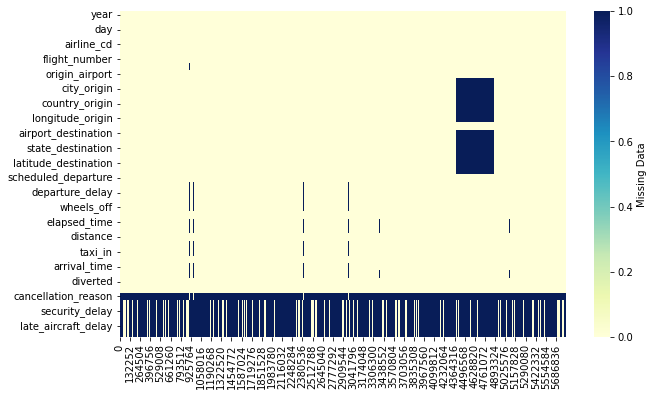

In [28]:
#plotting missing values
# code altered from: https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

> Our team then examined a breakdown of these missing values and noticed that there was a pattern of missing values. In attributes that seem closely related, we see the same number of missing values repeated several times. An example of this is displayed 11 attributes down with `airport_origin` to `country_origin`; all included attributes have exactly 486,165 missing values. This is due to the difference in the flights data set and airports data set having a different number of airport codes and these records will be removed in the next cell.

> The attribute `cancellation_reason` is composed of the recorded reason for a flight's cancellation; the majority of our records were not cancelled and as such, there were no values in this attribute. From our research, we found that the attribute’s filled rows had one of the following entries: A for Airline/Carrier, B for Weather, C for National Air System, and D for Security. With this data understanding, we decided to impute a 5th option which filled the remaining rows with the value `NC`, representing not cancelled. 

In [29]:
#Removing rows where Origin airport is NaN
df = df[df['airport_origin'].notna()]

In [30]:
df.cancellation_reason = df.cancellation_reason.fillna('NC') 

In [31]:
delay_fillna = ['arrival_delay', 'departure_delay', 'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'] 
df[delay_fillna] = df[delay_fillna].fillna(0)  

> The last attributes our team addressed are the origin/destination, latitude, and longitude attributes. Our team thought that the missing values for these 2 attributes were particularly weird because of the relatively small difference between the null counts of latitude and longitude and the attribute range starting with `airport_origin`. After sorting the original airport data set by longitude ascending, we discovered that there are 3 airports with missing latitudes and longitudes. As there were only 3 missing coordinates our team found said coordinates, imputed them, and re-ran our merger.   

#### Remaining Missing Values
> As for the remaining missing values we have decided to drop them. The remaining attributes are a combination of categorical, discrete, and 4 numerical attributes that we have decided are too heavily dependent on other attributes to fill in with a mean or median value. Any other numerical variaible with a missing value will later be imputed with a 0 to signify no delay for that variable.

> Since several rows contain the same route information, because airlines have set routes/schedules, we have decided to regard any rows with similar data as a valid part of our data set.  

#### Duplicate records: 

In [32]:
df[df.duplicated()] 

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay


#### Outliers

>  The below boxplots show that our airline data is extremely right skewed. The team will continue to evaluate how to deal with the outliers. The data will need to be transformed before performing any modeling. 

>Several methods of dealing with the outliers within our data currently consist of:

>**1. Keep data as is.**<br>
>**2. Remove any data point that is longer than 360 minutes.**<br>
>**3. Transform data using either a log scale or another scale.**

> If we were to transform the data in any way, we would need to consider intrepretability of the output of models and graphs.

***

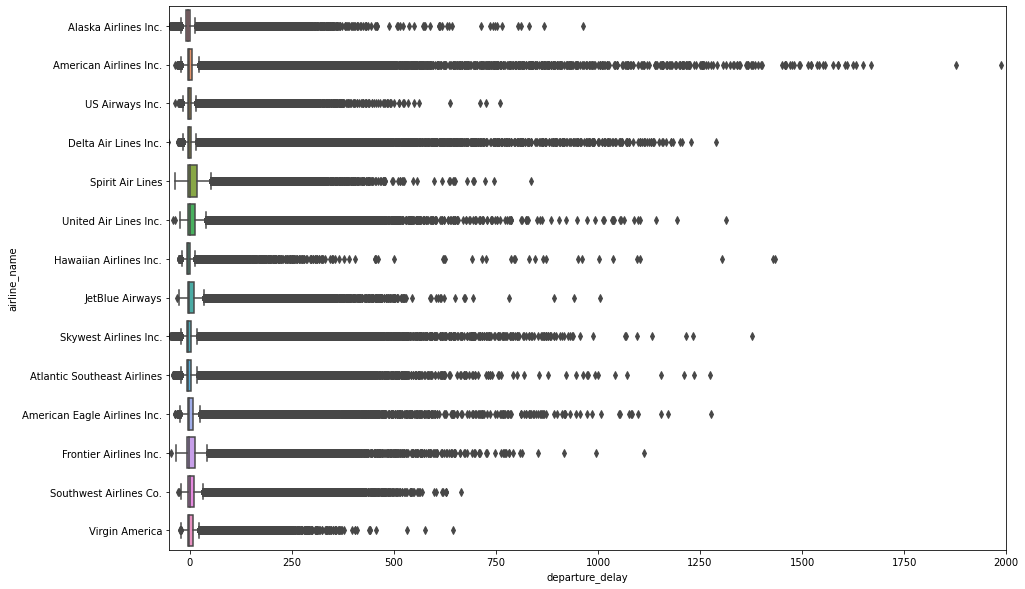

In [33]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="departure_delay",y='airline_name') 
plt.xlim(-50, 2000); 

In [34]:
df.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,5332914.0,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.249100e+06,5.332914e+06,5.246302e+06,5.246302e+06,5.332908e+06,5.231130e+06,5.231130e+06,5.332914e+06,5.242972e+06,5.242972e+06,5.332914e+06,5.242972e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06
mean,2015.0,6.207210e+00,1.568874e+01,3.919179e+00,2.178419e+03,3.663338e+01,-9.548208e+01,3.663327e+01,-9.548186e+01,1.330107e+03,1.336074e+03,9.620947e+00,1.610290e+01,1.357926e+03,1.417832e+02,1.371940e+02,1.136654e+02,8.228955e+02,1.471021e+03,7.438059e+00,1.493747e+03,1.475922e+03,4.792651e+00,2.691587e-03,1.639441e-02,2.537649e+00,1.461584e-02,3.556582e+00,4.456789e+00,5.608581e-01
std,0.0,3.383807e+00,8.774687e+00,1.993635e+00,1.760521e+03,5.999705e+00,1.815141e+01,5.999653e+00,1.815120e+01,4.843130e+02,4.974114e+02,3.731556e+01,8.991109e+00,4.990460e+02,7.525171e+01,7.430076e+01,7.229764e+01,6.077992e+02,5.237584e+02,5.686169e+00,5.079263e+02,5.279477e+02,3.941143e+01,5.181064e-02,1.269868e-01,1.326864e+01,9.460972e-01,2.203969e+01,2.094994e+01,9.019633e+00
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.348345e+01,-1.766460e+02,1.348345e+01,-1.766460e+02,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,3.000000e+00,8.000000e+00,2.000000e+00,7.310000e+02,3.289595e+01,-1.119778e+02,3.289595e+01,-1.119778e+02,9.170000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,1.054000e+03,4.000000e+00,1.110000e+03,1.058000e+03,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,6.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,3.736186e+01,-9.025803e+01,3.736186e+01,-9.025803e+01,1.325000e+03,1.331000e+03,-1.000000e+00,1.400000e+01,1.343000e+03,1.230000e+02,1.190000e+02,9.400000e+01,6.490000e+02,1.508000e+03,6.000000e+00,1.520000e+03,1.512000e+03,-4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.252000e+03,4.078839e+01,-8.168786e+01,4.078839e+01,-8.168786e+01,1.730000e+03,1.741000e+03,7.000000e+00,1.900000e+01,1.755000e+03,1.740000e+02,1.690000e+02,1.440000e+02,1.065000e+03,1.912000e+03,9.000000e+00,1.919000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.400000e+03,2.480000e+02,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


## df.describe:

>After running df.describe(), the team was able to identify variables that contain outliers. One example of this is our taxi_in variable. The mean for taxi_in is 7.438059e+00 while the max is 2.480000e+02. This indicates a large disparity. This disparity was also shown in other columns. When thinking about removing outliers such as this, the team recognizes that the mean will change for each variable. This is something we will continue to consider. 

***

# Data Understanding 2

>One of the attributes the team was interested in visualizing was the numeric response variable, `departure_delay`. The team wanted to look at the distribution of the variable to determine if it was uniform or not. To complete this, the team created a histogram for `departure_delay`. A histogram was chosen as an appropriate visualization as they visually communicate an attribute’s distribution.  

>As evidence below, the distribution of `departure_delay` proved to be right skewed. Knowing that having skewed variables in a model negatively impacts results, (skewed variables don’t meet statistical assumptions for regression), the team log transformed `departure_delay` to see if the distribution was corrected. After log transforming the response, the variable’s distribution was uniform.  

#### Histogram of Departure Delays

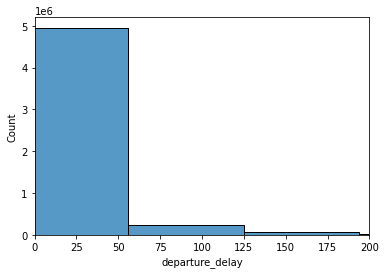

In [35]:
#Creating a histogram of the departure_delay variable. The variable is right skewed.

sns.histplot(data=df, x="departure_delay", bins=30) 
plt.xlim(0, 200); 

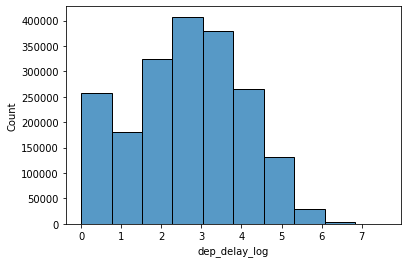

In [36]:
df_deep_delay = df.copy()
#Log transforming the departure delay variable. 
df_deep_delay['dep_delay_log'] = np.log(df['departure_delay']) 

#Distrbution of origin_airport variable.  
sns.histplot(df_deep_delay, x="dep_delay_log",bins=10); 

In [37]:
#creating a df for airlines and delay types 
airlinedelaytype = pd.DataFrame(df.groupby(['airline_name'])['air_system_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].sum()).reset_index()

airlinedelaytype['total'] = airlinedelaytype['air_system_delay'] + airlinedelaytype['airline_delay'] + airlinedelaytype['late_aircraft_delay'] + airlinedelaytype['weather_delay'] 

airlinedelaytype['pcnt_late_aircraft_delay'] = (airlinedelaytype['late_aircraft_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_airline_delay'] = (airlinedelaytype['airline_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_air_system_delay'] = (airlinedelaytype['air_system_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_weather_delay'] = (airlinedelaytype['weather_delay']/airlinedelaytype['total']) 

#creating a df for months and delay types 
monthdelaytype = pd.DataFrame(df.groupby(['month'])['air_system_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].sum()).reset_index() 

monthdelaytype ['total'] = monthdelaytype ['air_system_delay'] + monthdelaytype['airline_delay'] + monthdelaytype['late_aircraft_delay'] + monthdelaytype['weather_delay'] 

monthdelaytype ['pcnt_late_aircraft_delay'] = (monthdelaytype ['late_aircraft_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_airline_delay'] = (monthdelaytype['airline_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_air_system_delay'] = (monthdelaytype ['air_system_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_weather_delay'] = (monthdelaytype ['weather_delay']/monthdelaytype ['total']) 

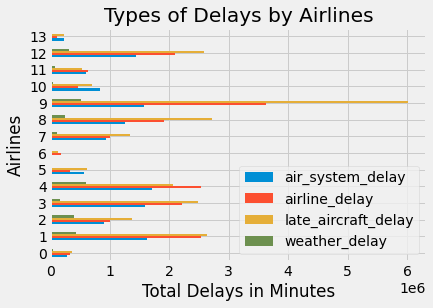

In [38]:
#plotting airlines against delay types 
airlinedelaytype1=airlinedelaytype[['airline_name','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=airlinedelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Airlines") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Airlines");

**Types of Delays by Airlines**: `Airline_delay` and `late_aircraft_delay` have the highest occurences from the types of delays. This makes sense as planes arriving late would contribute to an aircraft departing later than scheduled. Another area to explore would be to see the size of these delays as some airlines may be running magnatudes more than other airlines, giving them more opportunities to run into delays.

| # | Airline | Discussion |
| :--- | :--- | :--- |
|0| Alaska Airlines Inc. | Low delays across all categories |
|1| American Airlines Inc. | High delays across all categories |
|2| American Eagle Airlines Inc.| Moderate delays across all categories |
|3| Atlantic Southeast Airlines | High delays across all categories |
|4| Delta Air Lines Inc. | High delays across all categories |
|5|Frontier Airlines Inc. | Low delays across all categories |
|6| Hawaiian Airlines Inc.| Low delays across all categories |
|7| JetBlue Airways | Moderate delays across all categories |
|8| Skywest Airlines Inc. | High delays across all categories |
|9| Southwest Airlines Co. | High delays across all categories |
|10| Spirit Air Lines | Moderate delays across all categories |
|11| US Airways Inc | Moderate delays across all categories |
|12| United Air Lines Inc.| High delays across all categories |
|13| Virgin America | Low delays across all categories |

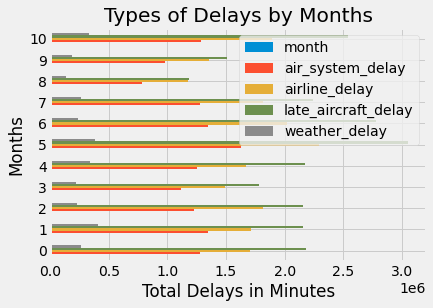

In [39]:
#Plotting Months Against Delay types 
monthdelaytype1=monthdelaytype[['month','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=monthdelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Months") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Months"); 

**Types of Delays by Month Chart** : By summing the total minutes for the types of delays per airline and per month we get similar trend in both charts where `late_aircraft_delay` and `airline_delay` have the largest total of delay minutes. We hypothesize that that system and mechanical issues are less likely to play influence flight delay than operating procedures. When we pair this with the most flights happen (starting at 5am) we theorize that once an airline is delayed, it will continue to try to play catch up throughout the day. This can be mitigated by plane speed but if standard operating procedures are not in place it is highly unlikely that an airline will get back on schedule. As the amount of flights decrease from 5a to 12a, this gives less opportunities for flights make up lost time which compounds the issue but could be an explanation why there are a lot of flights that have delays of less than 5 minutes.

| # | Month| Discussion |
| :--- | :--- | :--- |
| 0 | January | Moderate delays across all categories |
| 1 | February | Moderate delays across all categories |
| 2 | March | Moderate delays across all categories |
| 3 | April | Moderate delays across all categories |
| 4 | May | Moderate delays across all categories |
| 5 | June | High delays across all categories |
| 6 | July | High delays across all categories |
| 7 | August | High delays across all categories |
| 8 | September | Moderate delays across all categories |
| 9 | October | Moderate delays across all categories |
| 10 | November | Moderate delays across all categories |
| 11 | December | High delays across all categories |

#### Combination Plot to show Skewness of Data
> The below combination plot is used to determine look and feel of the skewness of delays across airlines. With the violin plot on the left, we are able to determine the majority of departures are well within a reasonable departure time, however each airline is severely right skewed and will have multiple outliers.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


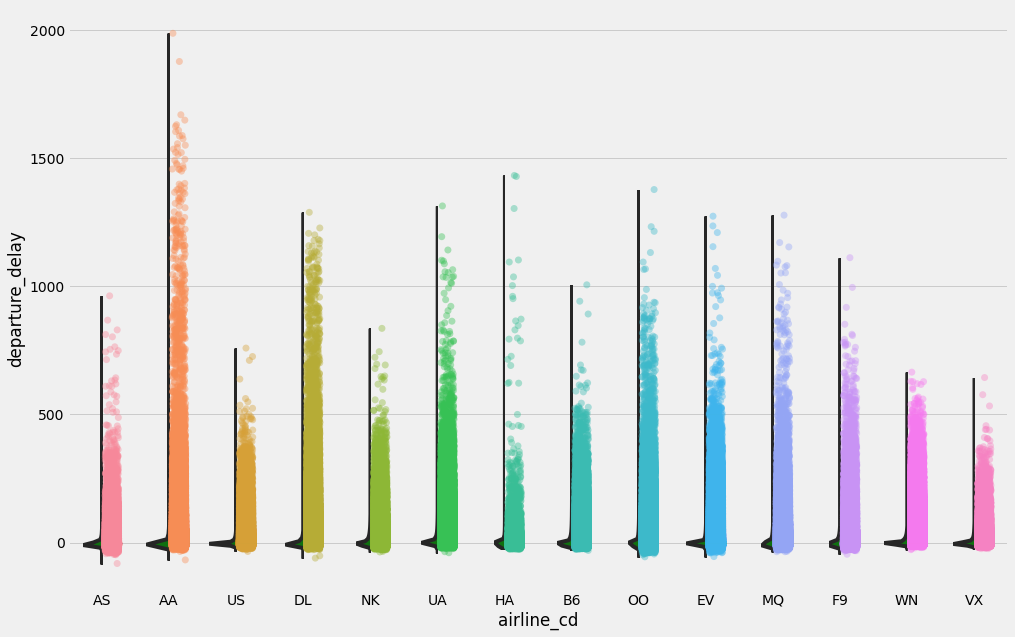

In [40]:
#adapted from online. Can't find website
plt.figure(figsize=(15, 10))
# Create violin plots without mini-boxplots inside.
ax = sns.violinplot(y='departure_delay',
                    x='airline_cd',
                    data=df,
                    color='green', 
                    cut=0,
                    inner=None)

# Clip the right half of each violin.
for item in ax.collections:
    x0, y0, width, height = item.get_paths()[0].get_extents().bounds
    item.set_clip_path(plt.Rectangle((x0, y0), width/2, height,
                       transform=ax.transData))

# Create strip plots with partially transparent points of different colors depending on the group.
num_items = len(ax.collections)
sns.stripplot(y='departure_delay',
              x='airline_cd',
              data=df,
              alpha=0.4,
              size=7)

# Shift each strip plot strictly below the correponding volin.
for item in ax.collections[num_items:]:
    item.set_offsets(item.get_offsets() + 0.15)


plt.legend(frameon=False, fontsize=15, loc='upper left');

#### Bar Chart of Average MPH per Airline

>We decided to explore a potential variable that could help mitigate an arrival delay, plane speed. The idea is that departure delay stops cumulating when the plane is in the air and arrival delays will start cumulating until the plane lands. Our assumption is each airline travels at a different speed due to factors like plane models, maintenance practices and weather. Since arrival time is redetermined, if a plane arrives early it is essentially mitigating minutes of delay by minimize `air_time` through plane speed. So it would be possible to have a departure delay but still arrive on time. 

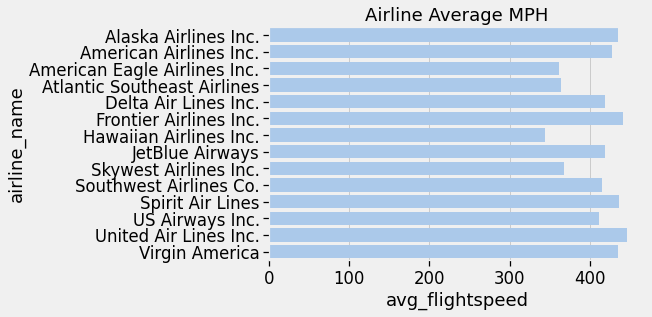

In [41]:
#establish airline flight speed

df_fs = df.copy()
df_fs['flightspeed'] = 60*df["distance"]/df["air_time"]

#setting airline mean speed 
airlinespeed = pd.DataFrame({'avg_flightspeed' : df_fs.groupby(['airline_name'])['flightspeed'].mean()}).reset_index() 
 
#Visualize average speed of each airline 
ax = sns.set_color_codes("pastel") 
sns.set_context("notebook", font_scale=1.5) 
ax = sns.barplot(x="avg_flightspeed", y="airline_name", data=airlinespeed, 
            label="accuracy", color="b").set(title='Airline Average MPH') 


#### Preprocessing
> Because we want to predict if an airplane is going to be delayed or not using classification models, we created a new field called `is_delay` from the `departure_delay` field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

> After creating the `is_delay` field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400.

> All fields with data types that are not integer or float will be removed as they are One Hot Encoded.
***

In [42]:
pd.set_option('display.max_columns', None)

In [43]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [44]:
#selecting subset of data set
airports = ['BHM']

In [45]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [46]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12514.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,12514.000000,12514.000000,12514.000000,12514.000000,12514.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,8.905865,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,2.517740,0.015583,3.450695,4.715918,0.438868
std,0.0,3.384375,8.763785,1.992624,1951.952017,1.421142e-14,1.421142e-14,4.990106,8.325266,445.126945,43.572598,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,14.630226,1.306530,31.062207,22.018629,6.745406
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [47]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

In [48]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

In [49]:
df_air.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   12514 non-null  int64  
 1   month                  12514 non-null  int64  
 2   day                    12514 non-null  int64  
 3   day_of_week            12514 non-null  int64  
 4   airline_cd             12514 non-null  object 
 5   airline_name           12514 non-null  object 
 6   flight_number          12514 non-null  int64  
 7   tail_number            12510 non-null  object 
 8   origin_airport         12514 non-null  object 
 9   airport_origin         12514 non-null  object 
 10  city_origin            12514 non-null  object 
 11  state_origin           12514 non-null  object 
 12  country_origin         12514 non-null  object 
 13  latitude_origin        12514 non-null  float64
 14  longitude_origin       12514 non-null  float64
 15

In [50]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='error',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [51]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

Final data set after One Hot Encoding is 12,514 x 1,777. Below is a condensed view of the data set as 1,777 columns is too long to print.

In [52]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Columns: 1777 entries, year to cancellation_reason_NC
dtypes: float64(1767), int64(10)
memory usage: 170.0 MB


***
# Modeling and Evaluation 1

> For Model and Evaluation 1, we ran 3 clustering models (Agglomerative Clustering, DBSCAN and K-Means). For each of the clusterings, we used our top features from our best Random Forest model in Lab 2. These columns were: `wheels_on`, `day`, `taxi_out`, and `taxi_in`. 

###  Clustering Preprocessing:
> Before running our selected columns, "wheels_on","day","taxi_out", "taxi_in" through the algorithms of Agglomerative Clustering, DBSCAN, and K-Means, the team checked for null and missing values in the columns, replaced missing and null values with zeros, and normalized our columns so they were on the same scale

In [53]:
AG = final_df[["wheels_on","day","taxi_out","taxi_in"]]
AG.head()

,wheels_on,day,taxi_out,taxi_in
321,846.0,1,19.0,6.0
730,823.0,1,9.0,5.0
734,839.0,1,12.0,16.0
2191,1035.0,1,16.0,11.0
2303,1125.0,1,11.0,5.0


In [54]:
AG.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wheels_on  12324 non-null  float64
 1   day        12514 non-null  int64  
 2   taxi_out   12334 non-null  float64
 3   taxi_in    12324 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 746.9 KB


In [55]:
#Imputing null and infinity values. 
print(np.any(np.isnan(AG)))
AG_clean = np.nan_to_num(AG)
#converting array to Data Frame
AG_clean = pd.DataFrame(AG_clean, columns = ['wheels_on','day','taxi_out','taxi_in'])

True


In [56]:
#Normalizing data. 
data_scaled = normalize(AG_clean)

In [57]:
#Conferting array to a DF. 
d2 = pd.DataFrame(data_scaled, columns = ['wheels_on','day','taxi_out','taxi_in'])
d2.head()

,wheels_on,day,taxi_out,taxi_in
0,0.999722,0.001182,0.022452,0.007090
1,0.999921,0.001215,0.010935,0.006075
2,0.999715,0.001192,0.014299,0.019065
3,0.999824,0.000966,0.015456,0.010626
4,0.999942,0.000889,0.009777,0.004444


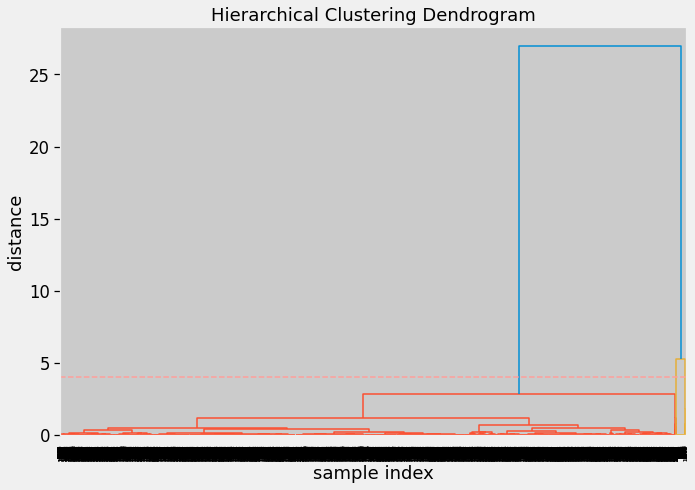

In [58]:
plt.figure(figsize=(10, 7))  
plt.title("Hierarchical Clustering Dendrogram")  
plt.xlabel('sample index')
plt.ylabel('distance')

#Code adapted from: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Perform-the-Hierarchical-Clustering.
dend = shc.dendrogram(shc.linkage(d2, method='ward'))
plt.axhline(y=4, color='r', linestyle='--')
plt.show()


### Begin Clustering:
***
#### Agglomerative Clustering:

#### Non-Normalized:


In [59]:
%%time 
#Code adapted from: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

clusteragrf = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
nn_agcl_fit = clusteragrf.fit(AG_clean)
nn_agcl_predict = nn_agcl_fit.fit_predict(AG_clean)

CPU times: user 3.36 s, sys: 231 ms, total: 3.59 s
Wall time: 3.58 s


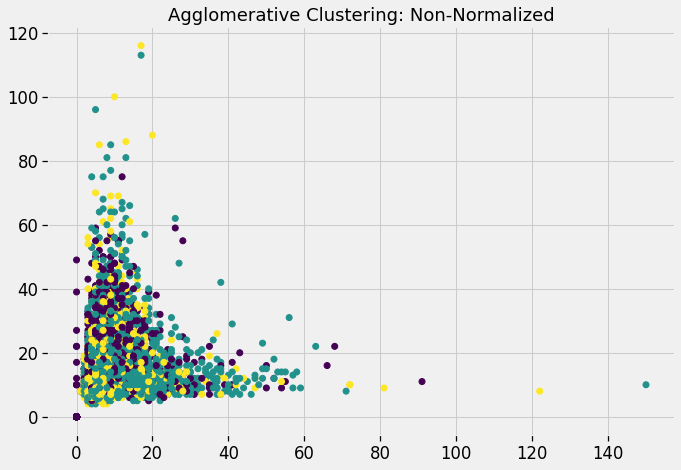

In [60]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(AG_clean['taxi_in'], AG_clean['taxi_out'], c=nn_agcl_fit.labels_)
plt.title('Agglomerative Clustering: Non-Normalized');

In [61]:
#Code altered from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
#Calculating silhouette score:
silhouette_score(AG_clean,nn_agcl_fit.labels_)

0.5975719884626517

In [62]:
#Code altered from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
#Calculating silhouette score:
davies_bouldin_score(AG_clean,nn_agcl_fit.labels_)

0.5017437087761872

#### Normalized:

In [63]:
%%time 
clusteragrf = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agcl_fit = clusteragrf.fit(d2)
agcl_predict = agcl_fit.fit_predict(d2)

CPU times: user 3.43 s, sys: 1.68 s, total: 5.11 s
Wall time: 3.42 s


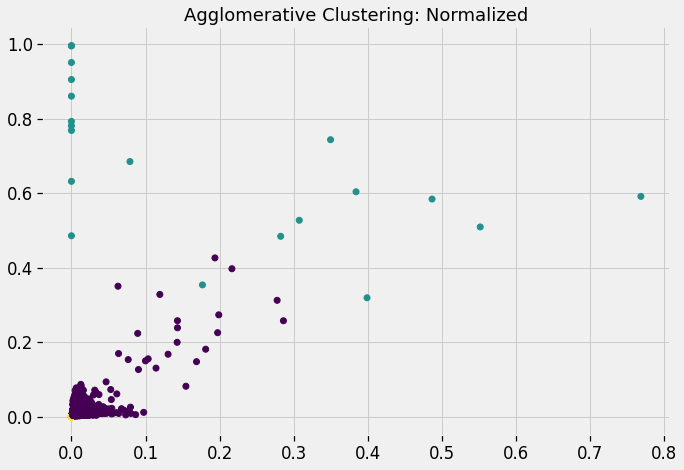

In [64]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=agcl_fit.labels_)
plt.title('Agglomerative Clustering: Normalized');

In [65]:
#Calculating silhouette score:

silhouette_score(d2,agcl_fit.labels_)

0.985507140241268

In [66]:

davies_bouldin_score(d2,agcl_fit.labels_)

0.44981191490914313

***
### DBSCAN:

#### Non-Normalized:

In [67]:
%%time 
#Code altered from: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
clustedb = DBSCAN(eps=0.125, min_samples=6)
nn_dbscan_fit = clustedb.fit(AG_clean)
nn_dbs_labels = nn_dbscan_fit.labels_ 

CPU times: user 62.2 ms, sys: 193 ms, total: 255 ms
Wall time: 29.8 ms


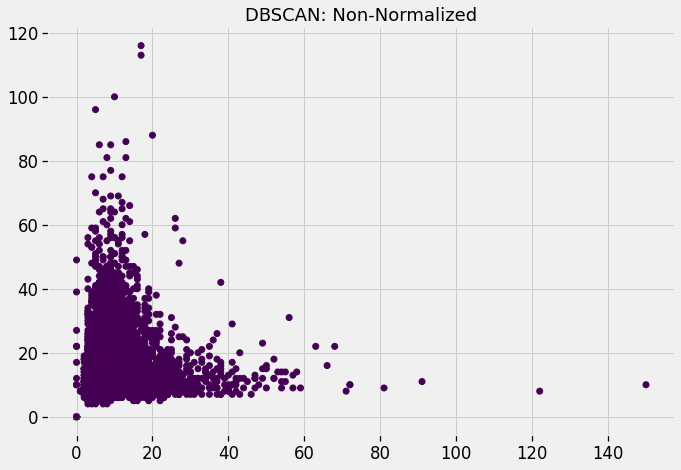

In [68]:
plt.figure(figsize=(10, 7))
plt.scatter(AG_clean['taxi_in'], AG_clean['taxi_out'], c=nn_dbscan_fit.labels_)
plt.title('DBSCAN: Non-Normalized');

In [69]:
silhouette_score(AG_clean,nn_dbs_labels)

0.5626104221646819

In [70]:
davies_bouldin_score(AG_clean,nn_dbs_labels)

0.2915882920346474

#### Normalized:

In [71]:
%%time 
clustedb = DBSCAN(eps=0.125, min_samples=6)
dbscan_fit = clustedb.fit(d2)
dbs_labels = dbscan_fit.labels_ 

CPU times: user 855 ms, sys: 1.83 s, total: 2.69 s
Wall time: 883 ms


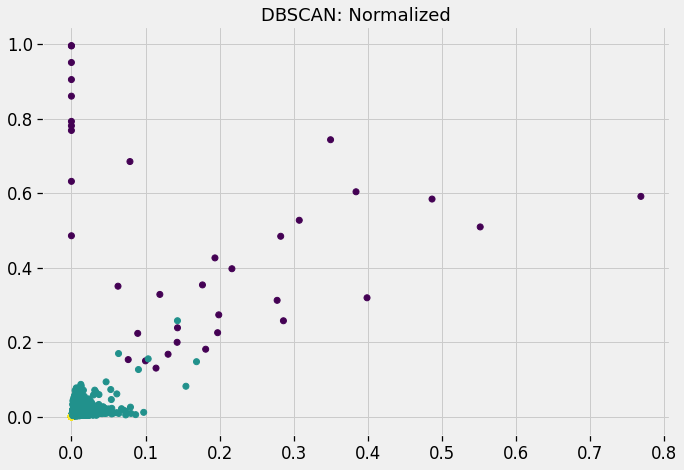

In [72]:
plt.figure(figsize=(10, 7))
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=dbscan_fit.labels_)
plt.title('DBSCAN: Normalized');

In [73]:
silhouette_score(d2,dbs_labels)

0.9811688064317405

In [74]:
davies_bouldin_score(d2,dbs_labels)

0.5893853172848803

***
### K-Means Clustering:

#### Non-Normalized:

In [75]:
%%time 
#Code altered from: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
clusterkm = KMeans(n_clusters=17, random_state=0)
nn_kmeans_fit = clusterkm.fit(AG_clean)
nn_kmn_labels = nn_kmeans_fit.labels_

CPU times: user 778 ms, sys: 1.68 s, total: 2.45 s
Wall time: 266 ms


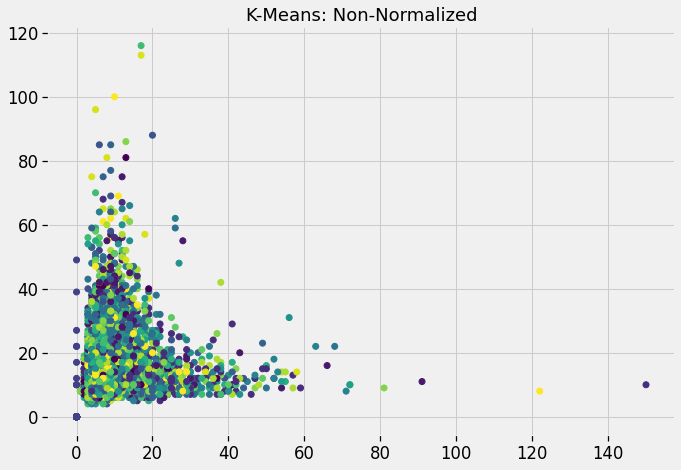

In [76]:
plt.figure(figsize=(10, 7))
plt.scatter(AG_clean['taxi_in'], AG_clean['taxi_out'], c=nn_kmeans_fit.labels_)
plt.title('K-Means: Non-Normalized');

In [77]:
silhouette_score(AG_clean,nn_kmn_labels)

0.6820176637530724

In [78]:
davies_bouldin_score(AG_clean,nn_kmn_labels)

0.395353924303625

#### Normalized:

In [79]:
%%time 
clusterkm = KMeans(n_clusters=17, random_state=0)
kmeans_fit = clusterkm.fit(d2)
kmn_labels = kmeans_fit.labels_

CPU times: user 1.25 s, sys: 1.95 s, total: 3.2 s
Wall time: 345 ms


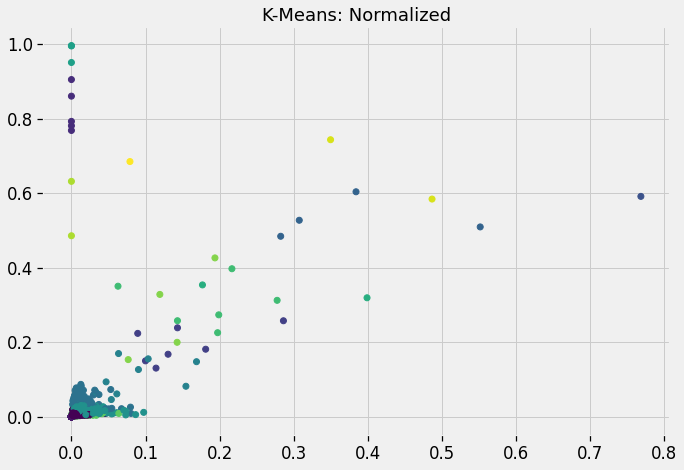

In [80]:
plt.figure(figsize=(10, 7))
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=kmeans_fit.labels_)
plt.title('K-Means: Normalized');

In [81]:
silhouette_score(d2,kmn_labels)

0.33221676789834054

In [82]:
davies_bouldin_score(d2,kmn_labels)

0.7579920974094467

***
# Modeling and Evaluation 2

> To compare our models, we determined that using a combined `silhouette` and `Davies Bouldin` score would best determine the optimal clustering algorithem.

> For our Normalized Data set, `Agglomerative Clustering` performed the best in both metrics, while in the non-normalized data set, the metrics were non-decisive and depended on the scoring metric. 

#### Non-Normalized Scores:

> For the `silhouette` scores, a higher score means a better clustering. `K-Means` clustering performed better than both `DBSCAN` and `Agglomerative Clustering` with a 0.682. `Agglomerative Clustering` performed slightly behind with a 0.597 and `DBSCAN` peformed the worst with a 0.562.

> The `Davies Bouldin` score were our second metric used to evaluate the clusterings and a lower score determines the better fitted clusters. `DBSCAN` outperformed both the `Agglomerative Clustering` and `K-Means` algorithems with a score of 0.291. `K-Means` modeling performed second best with a score of 0.395 and `DBSCAN` peformed the worst with a score of 0.501.

In [83]:
nn_sil_agc = silhouette_score(AG_clean,nn_agcl_fit.labels_)
nn_sil_dbsc = silhouette_score(AG_clean,nn_dbs_labels)
nn_sil_kmean = silhouette_score(AG_clean,nn_kmn_labels)

print(f'Silhouette Score for Agglomerative Clusting: {nn_sil_agc}')
print(f'Silhouette Score for DBSCAN: {nn_sil_dbsc}')
print(f'Silhouette Score for K-Means: {nn_sil_kmean}')

Silhouette Score for Agglomerative Clusting: 0.5975719884626517
Silhouette Score for DBSCAN: 0.5626104221646819
Silhouette Score for K-Means: 0.6820176637530724


In [84]:
nn_db_agc = davies_bouldin_score(AG_clean,nn_agcl_fit.labels_)
nn_db_dbsc = davies_bouldin_score(AG_clean,nn_dbs_labels)
nn_db_kmean = davies_bouldin_score(AG_clean,nn_kmn_labels)

print(f'Davies Bouldin Score for Agglomerative Clusting: {nn_db_agc}')
print(f'Davies Bouldin Score for DBSCAN: {nn_db_dbsc}')
print(f'Davies Bouldin Score for K-Means: {nn_db_kmean}')

Davies Bouldin Score for Agglomerative Clusting: 0.5017437087761872
Davies Bouldin Score for DBSCAN: 0.2915882920346474
Davies Bouldin Score for K-Means: 0.395353924303625


#### Normalized Scores:

> For the `silhouette` scores, a higher score means a better clustering. With this in mind, the `Agglomerative Clustering` algorithem performed slightly better than `DBSCAN` with a 0.985 compared to a 0.981. `K-Means` performed the worst in terms of `silhouette` scores with a 0.332.

> The `Davies Bouldin` score were our second metric used to evaluate the clusterings and a lower score determines the better fitted clusters. These scores reflected the same results as the `silhouette` scores with `Agglomerative Clustering` outperforming both `DBSCAN` and `K-Means` with a score of 0.449. `K-Means` again performed the worst with a `Davies Bouldin` score of 0.757.

In [85]:
sil_agc = silhouette_score(d2,agcl_fit.labels_)
sil_dbsc = silhouette_score(d2,dbs_labels)
sil_kmean = silhouette_score(d2,kmn_labels)

print(f'Silhouette Score for Agglomerative Clusting: {sil_agc}')
print(f'Silhouette Score for DBSCAN: {sil_dbsc}')
print(f'Silhouette Score for K-Means: {sil_kmean}')

Silhouette Score for Agglomerative Clusting: 0.985507140241268
Silhouette Score for DBSCAN: 0.9811688064317405
Silhouette Score for K-Means: 0.33221676789834054


In [86]:
db_agc = davies_bouldin_score(d2,agcl_fit.labels_)
db_dbsc = davies_bouldin_score(d2,dbs_labels)
db_kmean = davies_bouldin_score(d2,kmn_labels)

print(f'Davies Bouldin Score for Agglomerative Clusting: {db_agc}')
print(f'Davies Bouldin Score for DBSCAN: {db_dbsc}')
print(f'Davies Bouldin Score for K-Means: {db_kmean}')

Davies Bouldin Score for Agglomerative Clusting: 0.44981191490914313
Davies Bouldin Score for DBSCAN: 0.5893853172848803
Davies Bouldin Score for K-Means: 0.7579920974094467


***
# Modeling and Evaluation 3

> For each of the clustering algorithems we used, we plotted out normalized and non-normalized data to visually assess how the clustering was performing.

> As illustrated in the visualizations below,  for all models clustering performed better on our normalized data than it did on our non-normalized data. Evidence of this is seen how the first scatterplot below is able to identify 3 distinct clusters groupings, while our second scatterplot, shows all of the data points packed densely together. These results were expected because after putting the data on a similar scale, all models are poised to identify quality clusters.

#### Agglomerative Clustering Visualizations:

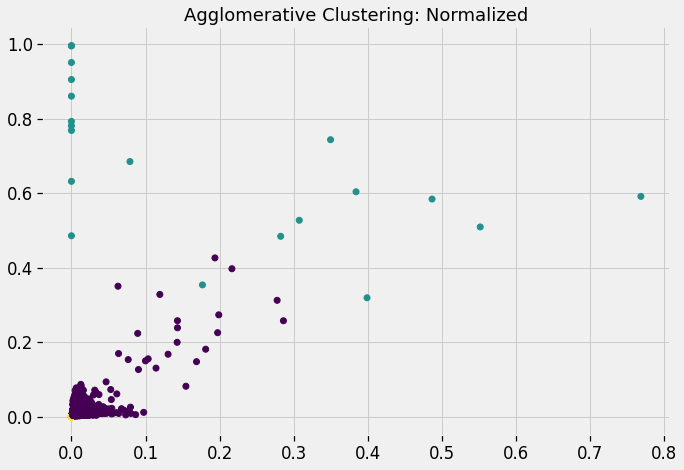

In [87]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=agcl_fit.labels_)
plt.title('Agglomerative Clustering: Normalized');

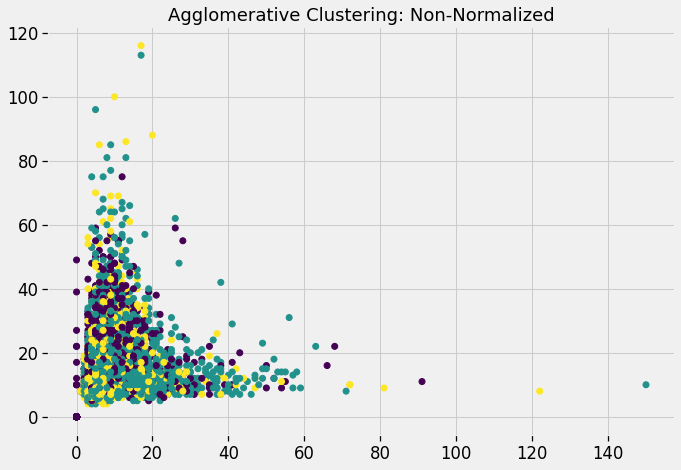

In [88]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(AG_clean['taxi_in'], AG_clean['taxi_out'], c=nn_agcl_fit.labels_)
plt.title('Agglomerative Clustering: Non-Normalized');

#### DBSCAN Visualizations:

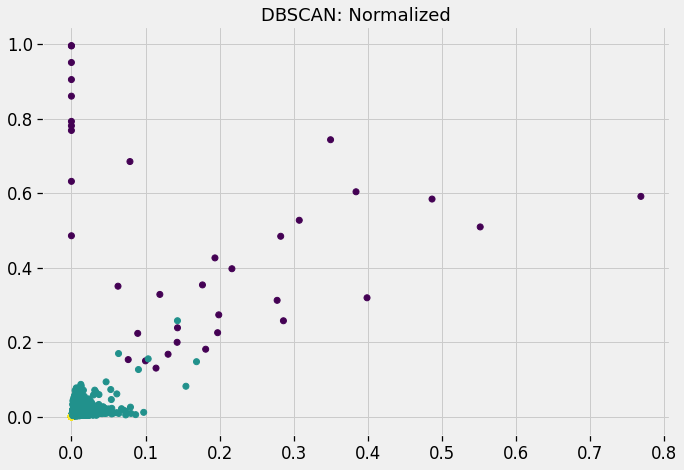

In [89]:
plt.figure(figsize=(10, 7))
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=dbscan_fit.labels_)
plt.title('DBSCAN: Normalized');

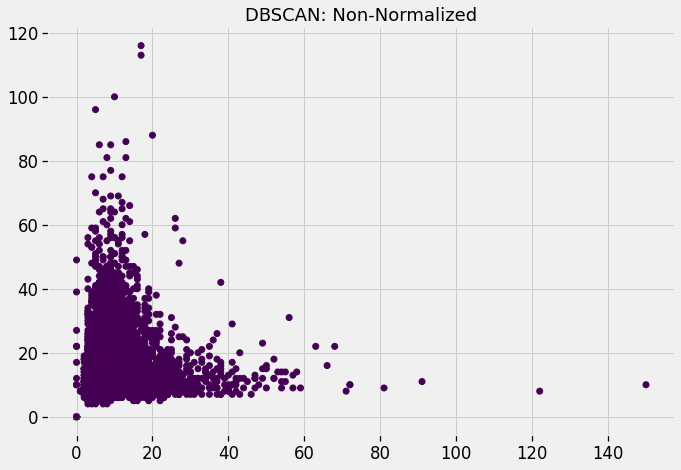

In [90]:
plt.figure(figsize=(10, 7))
plt.scatter(AG_clean['taxi_in'], AG_clean['taxi_out'], c=nn_dbscan_fit.labels_ )
plt.title('DBSCAN: Non-Normalized');

#### K-Means Visualizations:

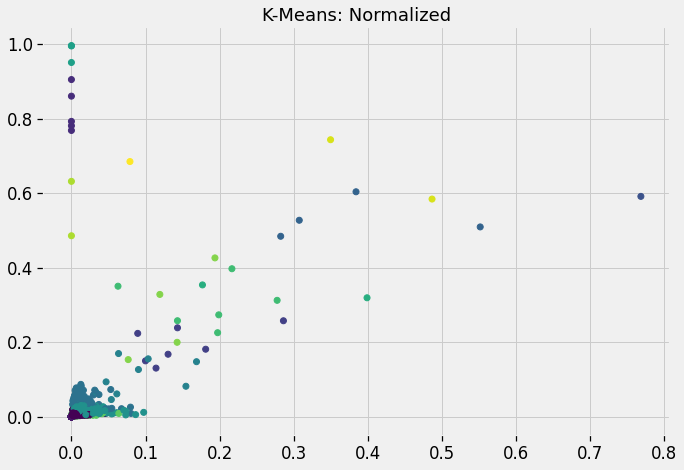

In [91]:
plt.figure(figsize=(10, 7))
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=kmeans_fit.labels_)
plt.title('K-Means: Normalized');

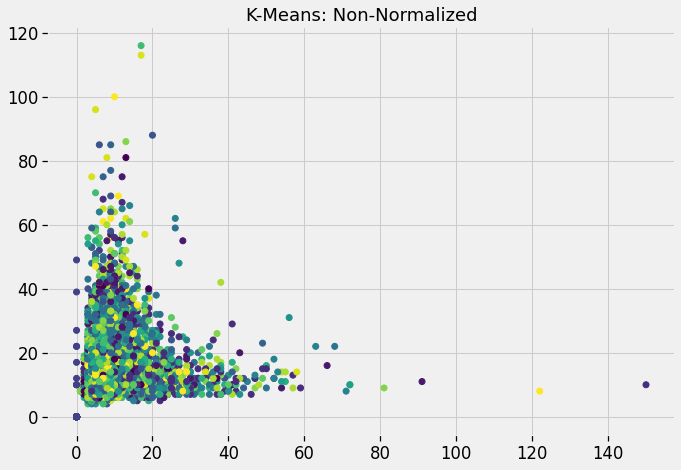

In [92]:
plt.figure(figsize=(10, 7))
plt.scatter(AG_clean['taxi_in'], AG_clean['taxi_out'], c=nn_kmeans_fit.labels_)
plt.title('K-Means: Non-Normalized');

***
# Modeling and Evaluation 4

> For airlines trying to accurately cluster types of delays, we would suggest potentially utilizing other algorithems to determine delay types. The dataset used in this notebook shows that not all algorithems are useful for every data set. If one was to use clustering in their model, we suggest that it be combined with another algorithem to more accurately cluster the data set. Clustering can but not always should be used alone in modeling. 

***
# Deployment
> Our best performing clustering model was our Agglomerative Clusting model on normalized data which contained the columns: `wheels_on`, `day`, `taxi_out`, `taxi_in`. These columns were selected as they were the top features in our best model from lab two. It is important to note that the team did fit an agglomerative clustering model, a DBSCAN model, and a k-means model. Given that our agglomerative clustering (clusteragf), model performed the best within the normalized data, the remainder of this writeup was written based on that model. 

> The team evaluated our models based on the metrics of silhouette score and the davies bouldin score. Our clusteragf model had a silhouette score of 0.98 and a davies bouldin score of .44. This indicates that our clusteragf model is good at identifying clusters in our airlines data and it indicates that clusters in our model are further apart and less dispersed.

> Although the performance of our clusteragf model was good according to our model metrics, the team is critical about how well our data set is suited for clustering. Our airline data set was segmented well originally including columns such as “taxi_in” and “taxi_out.” The team would expect these columns to cluster well, and they did as evidence in our clusteragf model. The team recognizes that if they had another data set, where they were trying to segment customers based on their purchasing patterns, that clustering would be better suited.

> Altogether, our team did achieve our goal. We successfully clustered our airline data set and obtained favorable model metrics.

> Our model would be useful for travelers and airlines. For travelers, having a flight delayed or cancelled can impact their travel plans, especially if there are connecting flights. Being able to identify airlines with higher rates of delays and cancellations can help them make better decisions. As an airline, this could be useful in identifying the major indicators in the different types of delays. For every airline flight that is cancelled or delayed is money that cannot be recouped and can result in additional paid compensation (lost luggage/ lodging expenses/ food vouchers) while still having to resolve the issue with the customer.

> The team would deploy our model over the internet so that our model could be accessible by employees of airlines and travelers at their convenience. Deploying our model over the internet would also ensure that it is highly available and it would enable compute to be scaled on-demand as needed.
Other datapoints that could be useful to add value to the model would be:

| # | Feature Addition | Description | Use Case |
| :--- | :--- | :--- |:--- |
| 1 | Aircraft Model | Plane Models  | This could be used to better understand flight efficiency based on age of and plane sophistication |
| 2 | Maintenance History | Last maintenance check, frequency of tune ups, number of major overhauls | Maintenance history could help determine how fast a plane gets in the air, the speeds it can reach and the turn around from one flight to another |
| 3 | Customer Satisfaction Score | We imagine a survey score on different categories like comfort, entertainment, etc | Customer satisfaction scores could be used to target high priority issues the resolve. An example would be If customers rated the flight with a low timeliness score, turn-around procedures would be identified and reviewed |
| 4 | Pilot Years of Experience | Measured in years or months,  could be categorized by position title  | Our assumption is pilot years of experience may influence how long it takes to get planes off the ground and how they handle weather or flight routes |
| 5 | Flight Costs | Measured in Dollars | This could be a measure for airlines that have little to no delay. Our assumption is punctuality and timeliness could influence consumer trust in an airline, the higher the demand would then in turn result in a higher price. Finding that influences flight costs may be correlated with flight efficiency |
| 6 | Flight Weight | Numeric: in lbs or kg  | Our assumption is a heavier plane takes longer to load and could influence the flight speed which would influence departure and arrival delays  |

 
> Once the model is productionized, the team recommends that it is updated quarterly. The team advises this timeline due to the fact that demand for airlines is highly variable and the team wants airlines to be able to capitalize on as much profit as possible.

# Exceptional Work

> For our exceptional work, we used our best model from the previous lab (Random Forest) and passed in our top clustering model (Agglomerative Clustering) to perform cross validation. Previously we used standard test/train split, but due to the type of data we are using, we altere the test/train split to use `TimeSeriesSplit` from `sklearn's` `model_selection` package. 

> Average accuracy was significantly lower than previous models. This could be due to previous model's splits utilizing future flights to predict past flight delays. The metrics from the model below should more accurately evaluate the model's predictive abilities. 

In [93]:
final_df[['year', 'month', 'day']] = final_df[['year', 'month', 'day']].astype(str)

In [94]:
#creating date field for TimeSeriesSplit
final_df['date'] = final_df[['year', 'month', 'day']].agg('-'.join, axis=1)
final_df['date'] = pd.to_datetime(final_df['date'])

In [95]:
final_df = final_df.sort_values(by='date')

In [96]:
tss = TimeSeriesSplit(n_splits = 11)

#reset index to date for sorting. 
final_df.set_index('date', inplace=True)

In [97]:
%%time 
#code altered from: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

clf = RandomForestClassifier(random_state = 0, criterion = 'entropy',n_estimators = 233)

params = []
for n_clust in range(2,20):
    # get the first clustering
    ag_clust = AgglomerativeClustering(n_clusters=n_clust, affinity='euclidean', linkage='ward') 
    ag_clust_fit  = ag_clust.fit(d2)
    newfeature_fare = ag_clust_fit.labels_ # the labels from kmeans clustering

    y = final_df['is_delay']
    X = d2
    X = np.column_stack((X,pd.get_dummies(newfeature_fare)))

    acc = cross_val_score(clf,X,y=y,cv=tss)
    params.append((n_clust,acc.mean()*100,acc.std()*100)) # save state

    print ("Clusters",n_clust,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 2 Average accuracy =  64.27325074158087 +- 3.3433321815799957
Clusters 3 Average accuracy =  64.06386320013961 +- 3.824428718301841
Clusters 4 Average accuracy =  64.30814866515443 +- 3.579972494512091
Clusters 5 Average accuracy =  64.08131216192638 +- 3.5889973729850135
Clusters 6 Average accuracy =  64.2470772989007 +- 3.4299306611948395
Clusters 7 Average accuracy =  64.20345489443378 +- 3.439349273108893
Clusters 8 Average accuracy =  64.0551387192462 +- 3.4012498140403054
Clusters 9 Average accuracy =  63.84575117780492 +- 3.3083387999014557
Clusters 10 Average accuracy =  64.22962833711394 +- 3.5032892030714207
Clusters 11 Average accuracy =  64.09003664281975 +- 3.4794822399800487
Clusters 12 Average accuracy =  63.950444948525565 +- 3.3871666462597054
Clusters 13 Average accuracy =  63.67998604083056 +- 3.57011472092307
Clusters 14 Average accuracy =  64.00279183388588 +- 3.2960068095187864
Clusters 15 Average accuracy =  63.90682254405863 +- 3.251247776775369
Cluster